In [1]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ddpg/#ddpg_continuous_actionpy
import random

import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

import json
import bridgestan as bs
from posteriordb import PosteriorDatabase

from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../..')
from tqdm.auto import trange

from src.rlmcmc.agent import Actor, QNetwork
from src.rlmcmc.env import RLMHEnvV31
from src.rlmcmc.utils import Args, Toolbox

In [2]:
# Load DataBase Locally
my_pdb = PosteriorDatabase("../../posteriordb/posterior_database")

# Load Dataset
posterior = my_pdb.posterior("test-banana-test-banana")
stan_code = posterior.model.stan_code_file_path()
stan_data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_code, stan_data)

# Extract log_target_pdf
log_p = model.log_density

In [3]:
# env setup
args = Args()
args.seed = 1234
args.log_target_pdf = log_p
args.total_timesteps = 10_000
args.batch_size = 64
args.learning_starts = args.batch_size
# args.learning_starts = 5_000
args.gamma = 0.01
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-5
args.policy_frequency = 50

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs).to(device)
actor = actor.double()
qf1 = QNetwork(envs).to(device)
qf1 = qf1.double()
qf1_target = QNetwork(envs).to(device)
qf1_target = qf1_target.double()
target_actor = Actor(envs).to(device)
target_actor = target_actor.double()
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.single_observation_space.dtype = np.float64
rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)

In [4]:
# TRY NOT TO MODIFY: start the game
obs, _ = envs.reset(seed=args.seed)

qf1_loss_list = []

In [5]:
for global_step in trange(args.total_timesteps):
    if global_step < args.learning_starts:
        actions = np.array(
            [
                np.hstack(
                    (
                        np.eye(args.sample_dim, dtype=np.float64).reshape(-1, args.sample_dim << 1),
                        np.eye(args.sample_dim, dtype=np.float64).reshape(-1, args.sample_dim << 1)
                    )
                ) for _ in range(envs.num_envs)
            ]
        ).reshape(1, -1)
    else:
        with torch.no_grad():
            actions = actor(torch.from_numpy(obs).to(device))

    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    obs = next_obs

    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        with torch.no_grad():
            next_state_actions = target_actor(data.next_observations)
            qf1_next_target = qf1_target(data.next_observations, next_state_actions)
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (qf1_next_target).view(-1)
        qf1_a_values = qf1(data.observations, data.actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

        qf1_loss_list.append(qf1_loss.item())

        # optimize the model
        q_optimizer.zero_grad()
        qf1_loss.backward()
        q_optimizer.step()

        if global_step % args.policy_frequency == 0:
            actor_loss = -qf1(data.observations, actor(data.observations)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # update the target network
            for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
env = envs.unwrapped.envs[0].env.env.env
observation_list = np.array([i for i in env.store_observation]).reshape(-1, env.sample_dim << 1)
action_list = np.array([i for i in env.store_action]).reshape(-1, env.sample_dim**2 << 1)

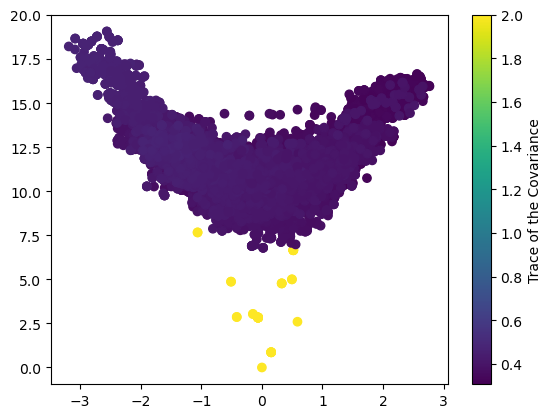

In [7]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
sc = ax.scatter(observation_list[1:, 0], observation_list[1:, 1], c=(action_list[:, 0] + action_list[:, 3]), cmap='viridis')

plt.colorbar(sc, label='Trace of the Covariance')
plt.show()


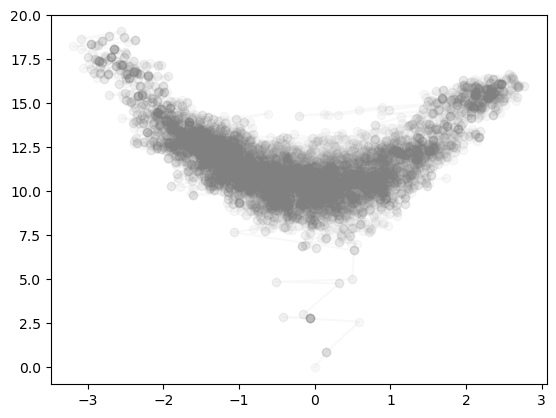

In [8]:
plt.plot(observation_list[1:, 0], observation_list[1:, 1], 'o-', color='grey', alpha=0.05)

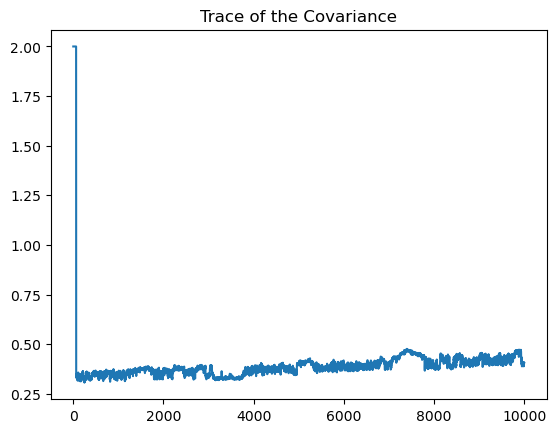

In [9]:
plt.plot(action_list[:, 0] + action_list[:, 3])
plt.title("Trace of the Covariance")
plt.show()

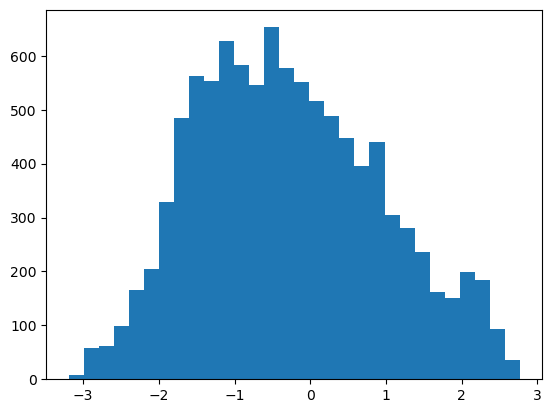

In [10]:
plt.hist(observation_list[:, 0], bins=30)
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


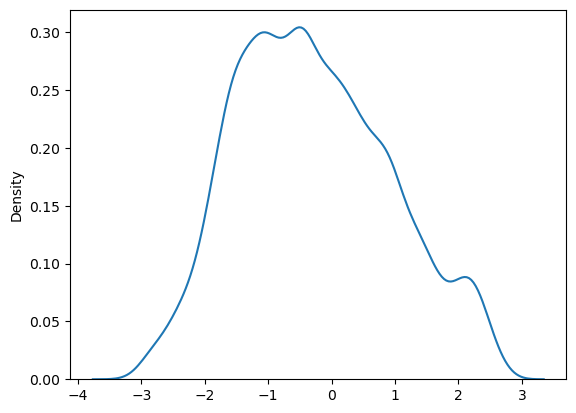

In [11]:
import seaborn as sns

sns.kdeplot(observation_list[:, 0])
plt.show()

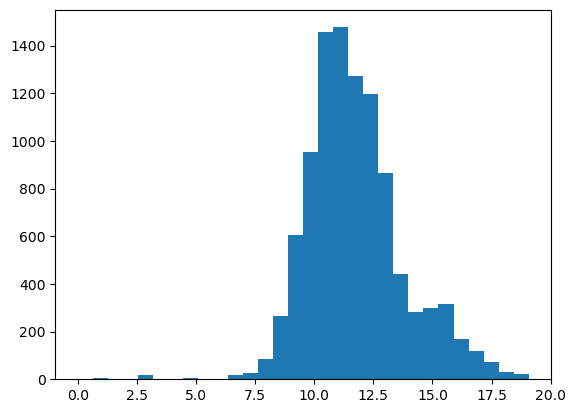

In [12]:
plt.hist(observation_list[:, 1], bins=30)
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


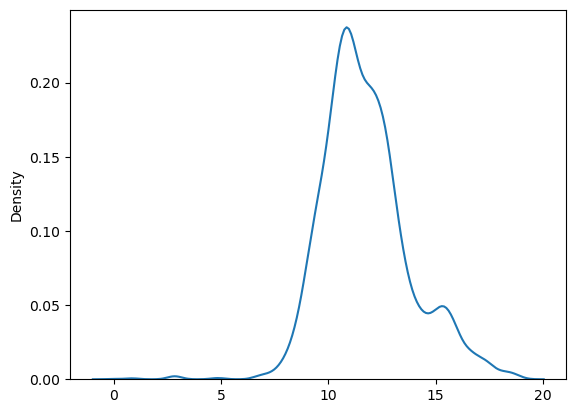

In [13]:
sns.kdeplot(observation_list[:, 1])
plt.show()

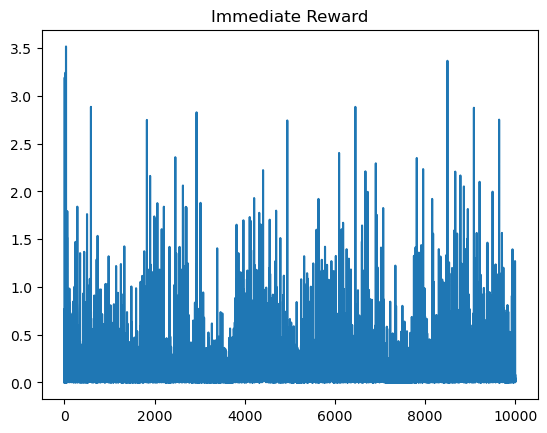

In [14]:
plt.plot(env.store_reward)
plt.title("Immediate Reward")
plt.show()

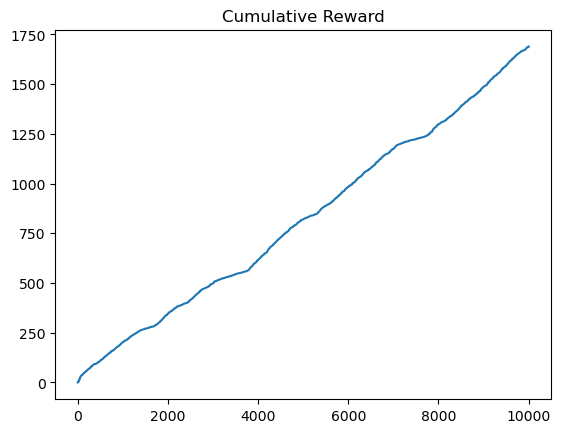

In [15]:
plt.plot(np.cumsum(env.store_reward))
plt.title("Cumulative Reward")
plt.show()

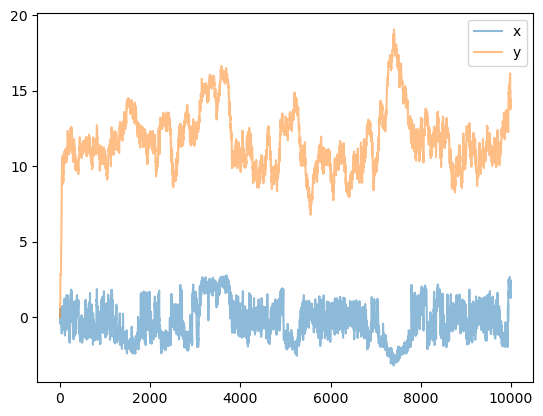

In [16]:
plt.plot(observation_list[:, 0], label="x", alpha=0.5)
plt.plot(observation_list[:, 1], label="y", alpha=0.5)
plt.legend()
plt.show()

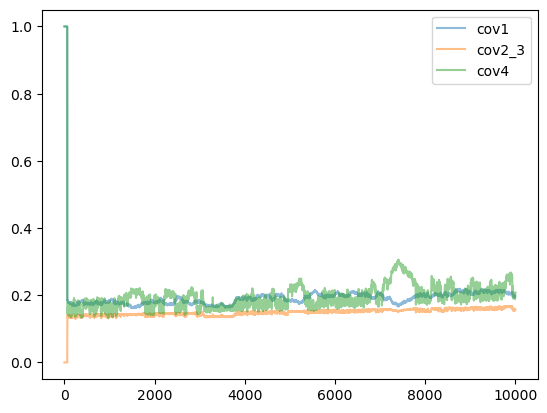

In [17]:
plt.plot(action_list[:, 0], label="cov1", alpha=0.5)
plt.plot(action_list[:, 1], label="cov2_3", alpha=0.5)
plt.plot(action_list[:, 3], label="cov4", alpha=0.5)
plt.legend()
plt.show()

In [18]:
np.sum(env.store_accetped_status)/len(env.store_accetped_status)

0.6512348765123488

In [19]:
import pandas as pd
df = pd.DataFrame(
    np.hstack(
        [
    observation_list[1:, 0:2],
    action_list[:, 0:4],
    np.array(env.store_reward).reshape(-1, 1)[1:],
    np.array(env.store_log_accetance_rate).reshape(-1, 1)[1:],
    np.array(env.store_accetped_status).reshape(-1, 1)[1:]
        ]
    ),
    columns=['x', 'y', 'cov1', 'cov2', 'cov3', 'cov4', 'rewards', 'log_alpha', 'accepted_status']
)
# Find the row with the largest value in the 'rewards' column
max_rewards_row = df.loc[
    [
        df['rewards'].idxmax() - 4,
        df['rewards'].idxmax() - 3,
        df['rewards'].idxmax() - 2,
        df['rewards'].idxmax() - 1,
        df['rewards'].idxmax(),
        df['rewards'].idxmax() + 1,
        df['rewards'].idxmax() + 2,
        df['rewards'].idxmax() + 3,
        df['rewards'].idxmax() + 4
    ]
]

max_rewards_row

,x,y,cov1,cov2,cov3,cov4,rewards,log_alpha,accepted_status
31,0.518367,6.654624,1.0,0.0,0.0,1.0,1.571576e-08,-18.981222,0.0
32,0.518367,6.654624,1.0,0.0,0.0,1.0,4.328865e-01,-1.425596,0.0
33,0.518367,6.654624,1.0,0.0,0.0,1.0,1.244416e-01,-3.120448,0.0
34,0.518367,6.654624,1.0,0.0,0.0,1.0,1.902740e-24,-56.249222,0.0
35,-1.061743,7.665209,1.0,0.0,0.0,1.0,3.518029e+00,0.000000,1.0
36,-1.061743,7.665209,1.0,0.0,0.0,1.0,1.096737e-02,-4.298280,0.0
37,-0.060285,8.381005,1.0,0.0,0.0,1.0,1.515282e+00,0.000000,1.0
38,-0.060285,8.381005,1.0,0.0,0.0,1.0,4.395899e-02,-4.185205,0.0
39,-0.576001,9.449844,1.0,0.0,0.0,1.0,1.408381e+00,0.000000,1.0


In [20]:
num = 1000
x = np.linspace(-5, 5, num)
y = np.linspace(5, 20, num)
X, Y = np.meshgrid(x, y)

Z = np.zeros((num, num))

In [21]:
for i in range(len(x)):
    for j in range(len(y)):
        Z[i, j] = np.exp(log_p(np.array([x[i], y[j]])))

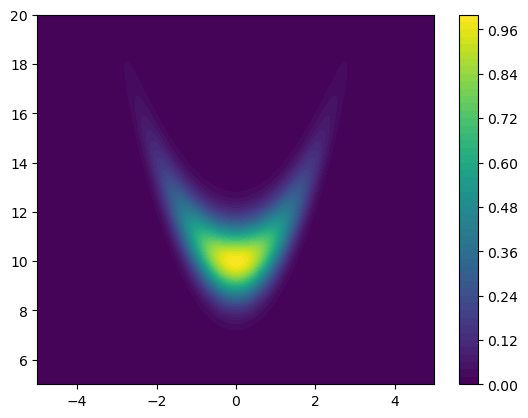

In [22]:
plt.contourf(X, Y, Z.T, 50, cmap='viridis')
plt.colorbar()
plt.show()

In [23]:
qf1_loss_list = np.array(qf1_loss_list)

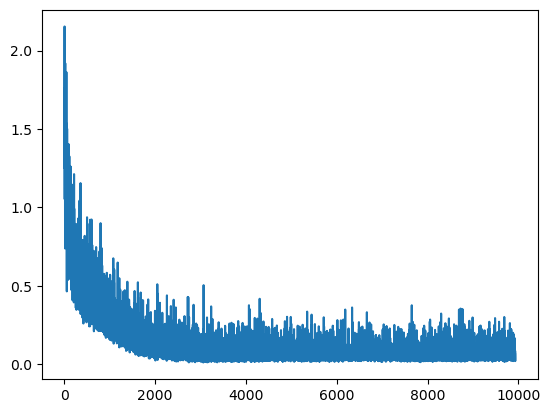

In [25]:
plt.plot(qf1_loss_list)